In [1]:
#@title Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format


In [2]:
#@title Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

## Represent data
The following code creates preprocessing layers outputting three features:

* `latitude` X `longitude` (as feature cross)
* `median_income`
* `population`

In [16]:
 inputs = {
    'latitude': tf.keras.Input(shape=(1,),
                              dtype=tf.float32,
                              name='latitude'),
    'longitude': tf.keras.Input(shape=(1,),
                               dtype=tf.float32,
                               name='longitude'),
    'median_income': tf.keras.Input(shape=(1,),
                                   dtype=tf.float32,
                                   name='median_income'),
    'population': tf.keras.layers.Input(shape=(1,),
                                       dtype=tf.float32,
                                       name='population')
}

# Normalization layer to normalize the median_income data
median_income = tf.keras.layers.Normalization(
    name='normalization_median_income',
    axis=None)
median_income.adapt(train_df['median_income'])
median_income = median_income(inputs.get('median_income'))

# Normalization layer to normalize the population data
population = tf.keras.layers.Normalization(
    name='normalization_population',
    axis=None)
population.adapt(train_df['population'])
population = population(inputs.get('population'))

# Create a list of numbers representig the bucktes boundaries for latitude.
# 20 buckets => 21 boundaries
latitude_boundaries = np.linspace(-3, 3, 21)

# Normalization layer for latitude data
latitude = tf.keras.layers.Normalization(
    name='normalization_latitude',
    axis=None
)
latitude.adapt(train_df['latitude'])
latitude = latitude(inputs.get('latitude'))

latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude') (latitude)

# same for longitude
longitude_boudaries = np.linspace(-3, 3, 21)
longitude = tf.keras.layers.Normalization(
    name='normalization_longitude',
    axis=None)
longitude.adapt(train_df['longitude'])
longitude = longitude(inputs.get('longitude'))

longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boudaries,
    name='discretization_longitude')(longitude)

# Cross feature between latitude and longitude into a single one-hot vector.
feature_cross = tf.keras.layers.HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boudaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

# Concatenate our inputs into a single tensor.
preprocessing_layers = tf.keras.layers.Concatenate()(
    [feature_cross, median_income, population])

print("Preprocessing layers defined.")

Preprocessing layers defined.


## Build a linear regression model as a baseline

In [17]:
#@title Plotting Function
def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [21]:
#@title Model creation and training functions

def create_model(my_inputs, my_outputs, my_learning_rate):
    """
    Create and compile a (simple) linear regression model.
    """
    model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=my_learning_rate),
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
    """
    Feed a dataset into the model in order to train it.
    """
    
    features = {name:np.array(value) for name, value in dataset.items()}
    label = train_median_house_value_normalized(
      np.array(features.pop(label_name)))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

    # Get details that will be useful for plotting the loss curve.
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse, history.history

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [22]:
#@title Define normalized label columns
# Create Normalization layers to normalize the median_house_value data.
# Because median_house_value is our label (i.e., the target value we're
# predicting), these layers won't be added to our model.
train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
train_median_house_value_normalized.adapt(
    np.array(train_df['median_house_value']))

test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(
    np.array(test_df['median_house_value']))

In [23]:
#@title Define linear regression model outputs
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

Epoch 1/15


C:\Users\andre\anaconda3\Lib\site-packages\keras\src\engine\functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'households'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/14 [==============================] - 2s 69ms/step - loss: 0.9193 - mean_squared_error: 0.9193 - val_loss: 0.7391 - val_mean_squared_error: 0.7391
Epoch 2/15
14/14 [==============================] - 0s 20ms/step - loss: 0.6600 - mean_squared_error: 0.6600 - val_loss: 0.5408 - val_mean_squared_error: 0.5408
Epoch 3/15
14/14 [==============================] - 0s 20ms/step - loss: 0.4981 - mean_squared_error: 0.4981 - val_loss: 0.4234 - val_mean_squared_error: 0.4234
Epoch 4/15
14/14 [==============================] - 0s 19ms/step - loss: 0.4107 - mean_squared_error: 0.4107 - val_loss: 0.3638 - val_mean_squared_error: 0.3638
Epoch 5/15
14/14 [==============================] - 0s 20ms/step - loss: 0.3694 - mean_squared_error: 0.3694 - val_loss: 0.3375 - val_mean_squared_error: 0.3375
Epoch 6/15
14/14 [==============================] - 0s 19ms/step - loss: 0.3525 - mean_squared_error: 0.3525 - val_loss: 0.3266 - val_mean_squared_error: 0.3266
Epoch 7/15
14/14 [===========================

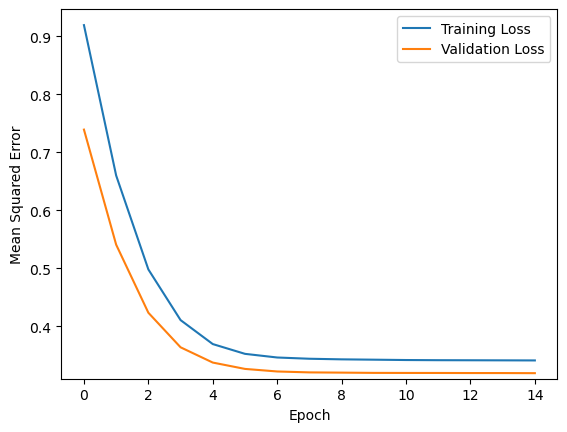


 Evaluate the linear regression model against the test set:
3/3 [==============================] - 0s 17ms/step - loss: 0.3609 - mean_squared_error: 0.3609


{'loss': 0.36093875765800476, 'mean_squared_error': 0.36093875765800476}

In [24]:
# Hyperparameters
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

validation_split = 0.2

outputs = get_outputs_linear_regression()

# Model's topography
my_model = create_model(inputs, outputs, learning_rate)

# Train the model
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

## Define a deep neural net model
The `get_outputs_dnn` function defines the topography of the deep neural net (DNN), specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `get_outputs_dnn` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.

The first `Dense` layer takes our previously defined `preprocessing_layers` as input.

In [51]:
def get_outputs_dnn():
    # Create a Dense layer with 20 nodes.
    dense_output = tf.keras.layers.Dense(units=10,
                                        activation='relu',
                                        name='hidden_dense_layer_1')(preprocessing_layers)
    dense_output = tf.keras.layers.Dense(units=6,
                                        activation='relu',
                                        name='hidden_dense_layer_2')(dense_output)
    dense_output = tf.keras.layers.Dense(units=1,
                                        name='dense_output')(dense_output)
    
    outputs = {
        'dense_output': dense_output
    }
    return outputs

## Build and train a deep neural network

Epoch 1/20


C:\Users\andre\anaconda3\Lib\site-packages\keras\src\engine\functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'households'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/14 [==============================] - 1s 23ms/step - loss: 0.7090 - mean_squared_error: 0.7090 - val_loss: 0.3970 - val_mean_squared_error: 0.3970
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3912 - mean_squared_error: 0.3912 - val_loss: 0.3229 - val_mean_squared_error: 0.3229
Epoch 3/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3440 - mean_squared_error: 0.3440 - val_loss: 0.3124 - val_mean_squared_error: 0.3124
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3333 - mean_squared_error: 0.3333 - val_loss: 0.3102 - val_mean_squared_error: 0.3102
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3306 - mean_squared_error: 0.3306 - val_loss: 0.3099 - val_mean_squared_error: 0.3099
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3281 - mean_squared_error: 0.3281 - val_loss: 0.3073 - val_mean_squared_error: 0.3073
Epoch 7/20
14/14 [==============================] 

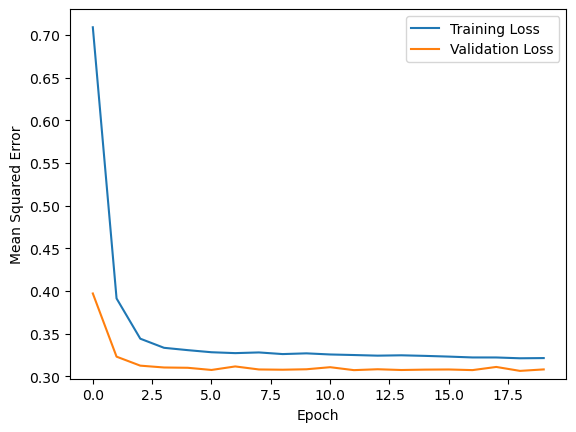


 Evaluate the new model against the test set:
3/3 [==============================] - 0s 7ms/step - loss: 0.3495 - mean_squared_error: 0.3495


{'loss': 0.34954965114593506, 'mean_squared_error': 0.34954965114593506}

In [52]:
# Hyperparameters
learning_rate = 0.01
epochs = 20
batch_size = 1000

label_name = "median_house_value"

validation_spit = 0.2

dnn_outputs = get_outputs_dnn()

# Create the model
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# Test the model
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(np.array(test_features.pop(label_name)))

print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)